# Wine Classification

In [106]:
# All import statements
import pandas as pd
import numpy as np
from scipy.io import loadmat
from scipy.special import expit
import matplotlib.pyplot as plt

In [107]:
# A code snippet to help results into a kaggle accepted csv
def results_to_csv(y_test, file_name):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1
    df.to_csv(file_name, index_label='ID')

The wine dataset, *data.mat*, consists of 6,000 sample points, each having 12 features.  The description of these features is provided in *data.mat*. The dataset includes a training set of 5,000 sample points and a test set of 1,000 sample points. Your classifier needs to predict whether 
a wine is white (class label 0) or red (class label 1).

Begin by normalizing the data with each feature's mean and standard deviation. You should use training data statistics to normalize both training and validation/test data. Then add a fictitious dimension. Whenever required, it is recommended that you tune hyperparameter values with cross-validation.

## Batch Gradient Descent

In [176]:
# Load and extract data
data = loadmat('../data/data.mat')
train_data = data['X']  # 5000 sample points with 12 features each (5000, 12)
train_labels = data['y']  # 5000 sample points with 1 label each (5000,)
test_data = data['X_test']  # 1000 sample points with 12 features each (1000, 12)
num_data = len(train_data)
num_features = len(train_data[0])
assert num_data == 5000, "Incorrect number of samples in train data (should be 5000)"
assert num_features == 12, "Incorrect number of features in train data (should be 12)"

***Normalize, append ones, and perform training-validation split***

Begin by normalizing the data with each feature's mean and standard deviation. You should use training data statistics to normalize both training and validation/test data. Then add a fictitious dimension. Whenever required, it is recommended that you tune hyperparameter values with cross-validation.

In [177]:
# Calculate the mean and standard deviation for all features
sample_means = [np.mean(train_data[:,i]) for i in range(num_features)]
sample_stds = [np.std(train_data[:,i]) for i in range(num_features)]

# Normalize each column via z = (x - mean) / std
for i in range(num_features):
    train_data[:,i] = (train_data[:,i] - sample_means[i]) / sample_stds[i]

# Add a fictitious column of ones which will help us deal with bias
train_data = np.append(train_data, np.ones((num_data, 1)), axis=1)
num_features_including_bias = num_features + 1
# Append data and labels together for shuffling
train_data_and_labels = np.append(train_data, train_labels, axis=1)

# Perform training-validation split
np.random.seed(42) # Set a random seed for deterministic behavior
np.random.shuffle(train_data_and_labels)
validation_size = 1000
validation_data_and_labels = train_data_and_labels[:validation_size]
train_data_and_labels = train_data_and_labels[validation_size:]

***Define logistic regression function and perform gradient descent***

In [178]:
# Logistic regression sigmoid function: weights = w, data = X
def logistic_regression(weights, data):
    num_samples = data.shape[0]
    prediction_sigmoids = np.zeros((num_samples))
    for i in range(num_samples):
        data_point = data[i]
        prediction_sigmoids[i] = np.divide(1,1+np.exp(-np.dot(data_point, weights)))
    return prediction_sigmoids

# Initial values to begin gradient descent on
w = np.zeros((num_features_including_bias)) # weights vector
gradient_cost_func = np.zeros((num_features_including_bias)) # gradient vector

In [179]:
num_iterations = 10000
regularization_parameter = 0.1
learning_rate = 0.0001
cost = np.zeros((num_iterations+1)) # np array to store cost at each step
X = train_data_and_labels[:,:num_features_including_bias]
# print(X.shape)
s = logistic_regression(weights=w, data=X) # predicted class

# Cost = -[ y*ln(s) + (1-y)*ln(1-s) + ||lambda||^2 ]
# y --> labels, which by construction are the last column of the design matrix
def cost_function(predictions, weights):
    return -np.dot(train_data_and_labels[:,-1],np.log(predictions))\
    -np.dot((1 - train_data_and_labels[:,-1]), np.log(1 - predictions))\
    + regularization_parameter * np.sum(np.square(weights))

cost_0 = cost_function(s,w) # Initial cost over all points
cost[0] = cost_0
for epoch in range(num_iterations):
    # grad(J(w)) = X^T(s-y) + lambda * w
    gradient_cost_func = np.dot(np.transpose(train_data_and_labels[:,:num_features_including_bias]),\
                                (s - train_data_and_labels[:,-1]))\
                                + (regularization_parameter * w)
    w = w - learning_rate * gradient_cost_func # GRADIENT DESCENT UPDATE RULE
    s = logistic_regression(w, train_data_and_labels[:,:num_features_including_bias])
    cost[epoch+1] = cost_function(s,w) # Updated cost over all points in next time step

In [181]:
# Check accuracy based on holdout (validation) set
s_validation = logistic_regression(w, validation_data_and_labels[:,:num_features_including_bias])
predictions = np.round(s_validation)
# print("Predictions:", predictions)
validation_labels = validation_data_and_labels[:,-1]
# print("Labels:", validation_labels)
accuracy = np.mean(predictions == validation_labels)
print(f"Validation accuracy is {accuracy * 100}%")

Predictions: (1000,)
Labels: (1000,)
Validation accuracy is 99.5%


### Kaggle Submission

In [182]:
# Use same feature engineering on test data
# Calculate the mean and standard deviation for all features of the test data
test_means = [np.mean(test_data[:,i]) for i in range(num_features)]
test_stds = [np.std(test_data[:,i]) for i in range(num_features)]

# Normalize each column via z = (x - mean) / std
for i in range(num_features):
    test_data[:,i] = (test_data[:,i] - test_means[i]) / test_stds[i]

# Add a fictitious column of ones which will help us deal with bias
test_data = np.append(test_data, np.ones((test_data.shape[0], 1)), axis=1)
s_test = logistic_regression(w, test_data) # w has been trained in the above cells
test_predictions = np.round(s_test)
results_to_csv(test_predictions, "wine_predictions.csv")

***Plot the cost over all iterations***

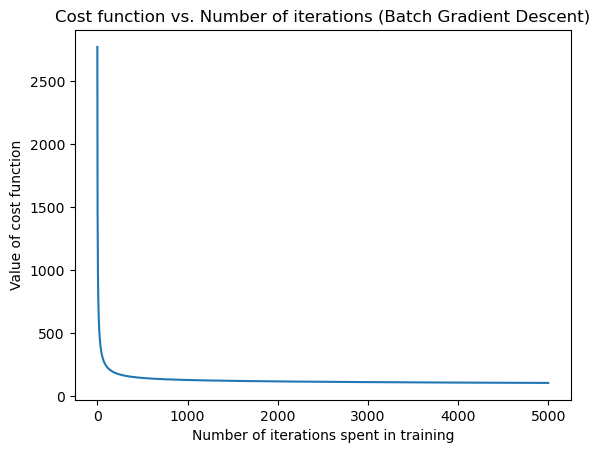

In [135]:
x_axis = np.arange(num_iterations + 1)
plt.plot(x_axis, cost)
plt.xlabel("Number of iterations spent in training")
plt.ylabel("Value of cost function")
plt.title("Cost function vs. Number of iterations (Batch Gradient Descent)")
plt.show();

## Stochastic Gradient Descent

**SGD with a constant step size (learning rate)**

In [136]:
# Reload all data
data = loadmat('../data/data.mat')
train_data = data['X']  # 5000 sample points with 12 features each (5000, 12)
train_labels = data['y']  # 5000 sample points with 1 label each (5000,)
test_data = data['X_test']  # 1000 sample points with 12 features each (1000, 12)
num_data = len(train_data)
num_features = len(train_data[0])
assert num_data == 5000, "Incorrect number of samples in train data (should be 5000)"
assert num_features == 12, "Incorrect number of features in train data (should be 12)"

# Calculate the mean and standard deviation for all features
sample_means = [np.mean(train_data[:,i]) for i in range(num_features)]
sample_stds = [np.std(train_data[:,i]) for i in range(num_features)]

# Normalize each column via z = (x - mean) / std
for i in range(num_features):
    train_data[:,i] = (train_data[:,i] - sample_means[i]) / sample_stds[i]

# Add a fictitious column of ones which will help us deal with bias
train_data = np.append(train_data, np.ones((num_data, 1)), axis=1)
num_features_including_bias = num_features + 1
# Append data and labels together for shuffling
train_data_and_labels = np.append(train_data, train_labels, axis=1)

# Perform training-validation split
np.random.seed(42) # Set a random seed for deterministic behavior
np.random.shuffle(train_data_and_labels)
validation_size = 1000
validation_data_and_labels = train_data_and_labels[:validation_size]
train_data_and_labels = train_data_and_labels[validation_size:]
train_size = train_data_and_labels.shape[0]

# Logistic regression sigmoid function: weights = w, data = X
def logistic_regression(weights, data):
    num_samples = data.shape[0]
    prediction_sigmoids = np.zeros((num_samples))
    for i in range(num_samples):
        data_point = data[i]
        prediction_sigmoids[i] = np.divide(1,1+np.exp(-np.dot(data_point, weights)))
    return prediction_sigmoids

# Initial values to begin stochastic gradient descent on
w = np.zeros((num_features_including_bias)) # weights vector
gradient_cost_func = np.zeros((num_features_including_bias)) # gradient vector

num_iterations = 5000
regularization_parameter = 0.1
learning_rate = 0.00001
cost = np.zeros((num_iterations+1)) # np array to store cost at each step
X = train_data_and_labels[:,:num_features_including_bias]
s = logistic_regression(weights=w, data=X) # vector containing predicted class

# Cost = -[ y*ln(s) + (1-y)*ln(1-s) + ||lambda||^2 ]
# y --> labels, which by construction are the last column of the design matrix
def cost_function(predictions, weights):
    return -np.dot(train_data_and_labels[:,-1],np.log(predictions))\
    -np.dot((1 - train_data_and_labels[:,-1]), np.log(1 - predictions))\
    + regularization_parameter * np.sum(np.square(weights))

cost_0 = cost_function(s,w) # Initial cost over all points
cost[0] = cost_0

sample_index = 0
for epoch in range(num_iterations):
    # Choose a random data point (np.random.seed has already been set to 42 above)
    if sample_index == train_size:
        np.random.shuffle(train_data_and_labels)
        sample_index = 0
    # For SGD, grad(J(w)) = (x_i)^T(s-y) + lambda * w
    gradient_cost_func = train_size * np.transpose(train_data_and_labels[sample_index,:num_features_including_bias]) \
                                * (s - train_data_and_labels[:,-1])[sample_index]\
                                + (regularization_parameter * w)
    w = w - learning_rate * gradient_cost_func # STOCHASTIC GRADIENT DESCENT UPDATE RULE
    s = logistic_regression(w, train_data_and_labels[:,:num_features_including_bias])
    cost[epoch+1] = cost_function(s,w) # Updated cost over all points in next time step
    sample_index += 1

4000


In [137]:
# Check accuracy based on holdout (validation) set
s_validation = logistic_regression(w, validation_data_and_labels[:,:num_features_including_bias])
predictions = np.round(s_validation)
validation_labels = validation_data_and_labels[:,-1]
accuracy = np.mean(predictions == validation_labels)
print(f"Validation accuracy is {accuracy * 100}%")

Validation accuracy is 99.0%


**SGD with a shrinking step size (learning rate)**

In [163]:
# Reload all data
data = loadmat('../data/data.mat')
train_data = data['X']  # 5000 sample points with 12 features each (5000, 12)
train_labels = data['y']  # 5000 sample points with 1 label each (5000,)
test_data = data['X_test']  # 1000 sample points with 12 features each (1000, 12)
num_data = len(train_data)
num_features = len(train_data[0])
assert num_data == 5000, "Incorrect number of samples in train data (should be 5000)"
assert num_features == 12, "Incorrect number of features in train data (should be 12)"

# Calculate the mean and standard deviation for all features
sample_means = [np.mean(train_data[:,i]) for i in range(num_features)]
sample_stds = [np.std(train_data[:,i]) for i in range(num_features)]

# Normalize each column via z = (x - mean) / std
for i in range(num_features):
    train_data[:,i] = (train_data[:,i] - sample_means[i]) / sample_stds[i]

# Add a fictitious column of ones which will help us deal with bias
train_data = np.append(train_data, np.ones((num_data, 1)), axis=1)
num_features_including_bias = num_features + 1
# Append data and labels together for shuffling
train_data_and_labels = np.append(train_data, train_labels, axis=1)

# Perform training-validation split
np.random.seed(42) # Set a random seed for deterministic behavior
np.random.shuffle(train_data_and_labels)
validation_size = 1000
validation_data_and_labels = train_data_and_labels[:validation_size]
train_data_and_labels = train_data_and_labels[validation_size:]
train_size = train_data_and_labels.shape[0]

# Logistic regression sigmoid function: weights = w, data = X
def logistic_regression(weights, data):
    num_samples = data.shape[0]
    prediction_sigmoids = np.zeros((num_samples))
    for i in range(num_samples):
        data_point = data[i]
        prediction_sigmoids[i] = np.divide(1,1+np.exp(-np.dot(data_point, weights)))
    return prediction_sigmoids

# Initial values to begin stochastic gradient descent on
w = np.zeros((num_features_including_bias)) # CONSTANT weights vector
w_shrinking = np.zeros((num_features_including_bias)) # SHRINKING weights vector
gradient_cost_func = np.zeros((num_features_including_bias)) # CONSTANT gradient vector
gradient_cost_func_shrinking = np.zeros((num_features_including_bias)) # SHRINKING gradient vector

num_iterations = 5000
regularization_parameter = 0.2
learning_rate_const = 0.000001
learning_rate_shrinking = 0.00001 # delta
cost = np.zeros((num_iterations+1)) # constant step size
cost_shrinking = np.zeros((num_iterations+1)) # shrinking step size
X = train_data_and_labels[:,:num_features_including_bias]
s = logistic_regression(weights=w, data=X) # vector containing predicted class
s_shrinking = logistic_regression(weights=w, data=X) # SHRINKING LEARNING RATE

# Cost = -[ y*ln(s) + (1-y)*ln(1-s) + ||lambda||^2 ]
# y --> labels, which by construction are the last column of the design matrix
def cost_function(predictions, weights):
    return -np.dot(train_data_and_labels[:,-1],np.log(predictions))\
    -np.dot((1 - train_data_and_labels[:,-1]), np.log(1 - predictions))\
    + regularization_parameter * np.sum(np.square(weights))

cost_0 = cost_function(s,w) # Initial cost over all points (initially same for both)
cost[0] = cost_0 # CONSTANT LEARNING RATE
cost_shrinking[0] = cost_0 # SHRINKING LEARNING RATE

sample_index = 0
for epoch in range(num_iterations):
    learning_rate_shrinking = np.divide(learning_rate_shrinking, epoch + 1) # SHRINKING LEARNING RATE
    
    # Choose a random data point (np.random.seed has already been set to 42 above)
    if sample_index == train_size:
        np.random.shuffle(train_data_and_labels)
        sample_index = 0
    
    # For SGD, grad(J(w)) = (x_i)^T(s-y) + lambda * w
    gradient_cost_func = train_size * np.transpose(train_data_and_labels[sample_index,:num_features_including_bias]) \
                                * (s - train_data_and_labels[:,-1])[sample_index]\
                                + (regularization_parameter * w) # CONSTANT LEARNING RATE
    gradient_cost_func_shrinking = train_size * np.transpose(train_data_and_labels[sample_index,:num_features_including_bias]) \
                                * (s_shrinking - train_data_and_labels[:,-1])[sample_index]\
                                + (regularization_parameter * w) # SHRINKING LEARNING RATE
    
    # STOCHASTIC GRADIENT DESCENT UPDATE RULE
    w = w - learning_rate_const * gradient_cost_func # CONSTANT LEARNING RATE
    w_shrinking = w_shrinking - learning_rate_shrinking * gradient_cost_func_shrinking # SHRINKING LEARNING RATE
    s = logistic_regression(w, train_data_and_labels[:,:num_features_including_bias]) # CONSTANT LEARNING RATE
    s_shrinking = logistic_regression(w_shrinking, train_data_and_labels[:,:num_features_including_bias]) # SHRINKING LEARNING RATE
    
    # Update cost over all points in next time step
    cost[epoch+1] = cost_function(s,w) # CONSTANT LEARNING RATE
    cost_shrinking[epoch+1] = cost_function(s_shrinking, w_shrinking) # SHRINKING LEARNING RATE
    sample_index += 1

# Check accuracy based on holdout (validation) set
s_validation = logistic_regression(w, validation_data_and_labels[:,:num_features_including_bias]) # CONSTANT LEARNING RATE
s_validation_shrinking = logistic_regression(w_shrinking, validation_data_and_labels[:,:num_features_including_bias]) # SHRINKING LEARNING RATE
predictions = np.round(s_validation) # CONSTANT LEARNING RATE
predictions_shrinking = np.round(s_validation_shrinking) # SHRINKING LEARNING RATE
validation_labels = validation_data_and_labels[:,-1]
accuracy = np.mean(predictions == validation_labels) # CONSTANT LEARNING RATE
accuracy_shrinking = np.mean(predictions_shrinking == validation_labels) # SHRINKING LEARNING RATE
print(f"Validation accuracy with a constant learning rate is {accuracy * 100}%") # CONSTANT LEARNING RATE
print(f"Validation accuracy with a shrinking learning rate is {accuracy_shrinking * 100}%") # SHRINKING LEARNING RATE

Validation accuracy with a constant learning rate is 98.8%
Validation accuracy with a shrinking learning rate is 85.2%


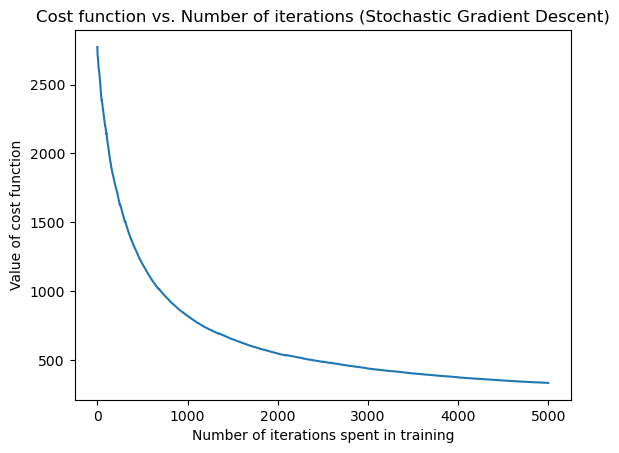

In [ ]:
# Plot the trend in convergence for SGD
x_axis = np.arange(num_iterations + 1)
plt.plot(x_axis, cost)
plt.xlabel("Number of iterations spent in training")
plt.ylabel("Value of cost function")
plt.title("Cost function vs. Number of iterations (Stochastic Gradient Descent)")
plt.show();

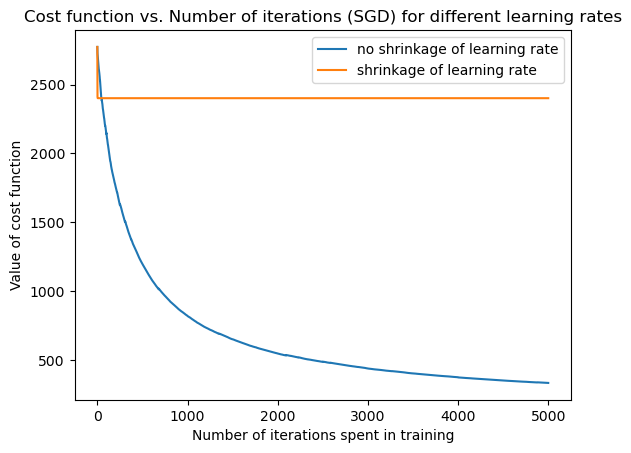

In [166]:
# Plot the trend in convergence for both learning rates for comparison
x_axis = np.arange(num_iterations + 1)
plt.plot(x_axis, cost, label="no shrinkage of learning rate")
plt.plot(x_axis, cost_shrinking, label="shrinkage of learning rate")
plt.xlabel("Number of iterations spent in training")
plt.ylabel("Value of cost function")
plt.title("Cost function vs. Number of iterations (SGD) for different learning rates")
plt.legend()
plt.show();

# L1-regularization, L2-regularization, and Sparsity

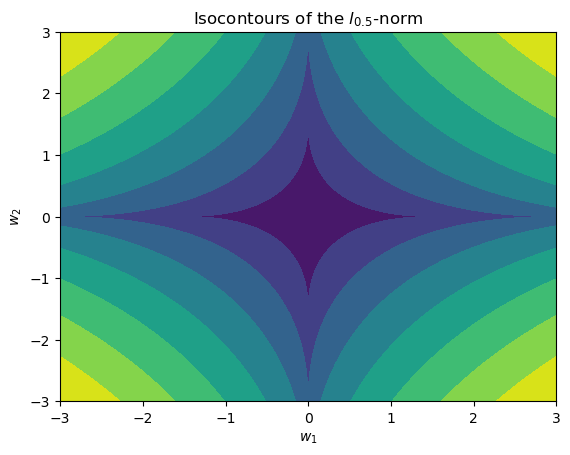

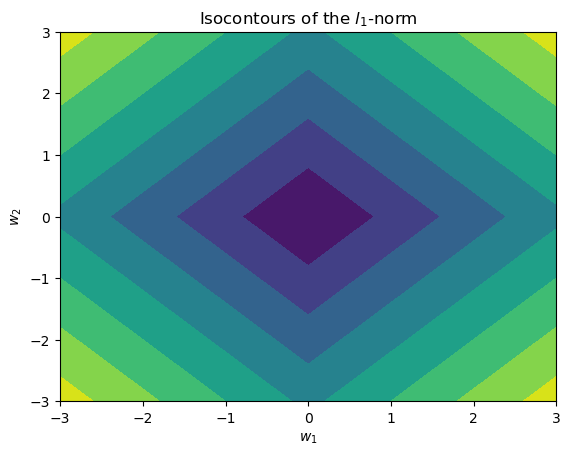

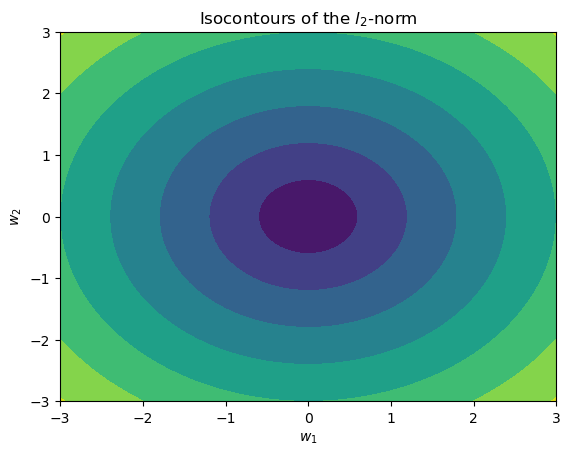

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def lp_norm(p, x, y):
    return (np.abs(x)**p + np.abs(y)**p)**(1/p)

mesh_x = np.linspace(-3, 3, 500)
mesh_y = np.linspace(-3, 3, 500)
x, y = np.meshgrid(mesh_x, mesh_y)

surface = lp_norm(0.5, x, y) # Part 6.1(a)
plt.contourf(x, y, surface)
plt.title("Isocontours of the $l_{0.5}$-norm")
plt.xlabel("$w_1$")
plt.ylabel("$w_2$")
plt.show()

surface = lp_norm(1, x, y) # Part 6.1(b)
plt.contourf(x, y, surface)
plt.title("Isocontours of the $l_1$-norm")
plt.xlabel("$w_1$")
plt.ylabel("$w_2$")
plt.show()

surface = lp_norm(2, x, y) # Part 6.1(c)
plt.contourf(x, y, surface)
plt.title("Isocontours of the $l_2$-norm")
plt.xlabel("$w_1$")
plt.ylabel("$w_2$")
plt.show()